In [1]:
import pandas as pd
import numpy as np

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import xarray as xr
import torch
import os

# preprocess.py contains the function to load and preprocess the ice velocity data
from real_preprocess import load_and_preprocess_ice_velocity_data, create_flux_df_for_region, visualise_flux, visualise_flux_train_test_split, find_very_close_points, df_to_tensor

/home/kim/eccv/.conda/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Load data sets

In [2]:
### ICE THICKNESS DATA ###
# Bedmap 1 + 2 + 3 
path_to_bedmap_data_folder = "/home/kim/data/bedmap_raw_data_test"
path_bedmap123_byrd = os.path.join(path_to_bedmap_data_folder, "bedmap123_byrd_catchment.csv")
thickness_points = pd.read_csv(path_bedmap123_byrd)

### ICE VELOCITY DATA ###
# NSIDC MEaSUREs Antarctic Ice Velocity Map
# NOTE: The coordinates in load_and_preprocess_ice_velocity_data() need to be large enough to not produce NaN in the interpolation
ice_vel_file_path = '/home/kim/data/nsidc/antarctica_ice_velocity_450m_v2.nc'
# Function to load and preprocess the ice velocity data as xarray
velocity_grid = load_and_preprocess_ice_velocity_data(ice_vel_file_path)

# Check
print(f"Check number of rows Nan thickness:", thickness_points["t"].isna().sum())
print(f"Check number of rows Nan velocity:", np.isnan(velocity_grid.VX.values).sum())

Check number of rows Nan thickness: 0
Check number of rows Nan velocity: 0


In [3]:
velocity_grid

<xarray.Dataset>
Dimensions:       (x: 523, y: 522)
Coordinates:
  * x             (x) float64 3.900e+05 3.905e+05 ... 6.245e+05 6.25e+05
  * y             (y) float64 -7.253e+05 -7.258e+05 ... -9.593e+05 -9.598e+05
    lat           (y, x) float64 ...
    lon           (y, x) float64 ...
Data variables:
    coord_system  |S1 ...
    VX            (y, x) float32 0.9081 0.8489 0.7113 ... -12.94 -12.82 -12.85
    VY            (y, x) float32 ...
    STDX          (y, x) float32 ...
    STDY          (y, x) float32 ...
    ERRX          (y, x) float32 ...
    ERRY          (y, x) float32 ...
    CNT           (y, x) int32 ...
Attributes: (12/26)
    Conventions:               CF-1.6
    Metadata_Conventions:      CF-1.6, Unidata Dataset Discovery v1.0, GDS v2.0
    standard_name_vocabulary:  CF Standard Name Table (v22, 12 February 2013)
    id:                        vel_nsidc.CF16.nc
    title:                     MEaSURES Antarctica Ice Velocity Map 450m spacing
    product_version:            
    ...                        ...
    spatial_resolution:        450m
    time_coverage_start:       1995-01-01
    time_coverage_end:         2016-12-31
    project:                   NASA/MEaSUREs
    creator_name:              J. Mouginot
    license:                   No restrictions on access or use

(389825.0, 625175.0, -959975.0, -725075.0)

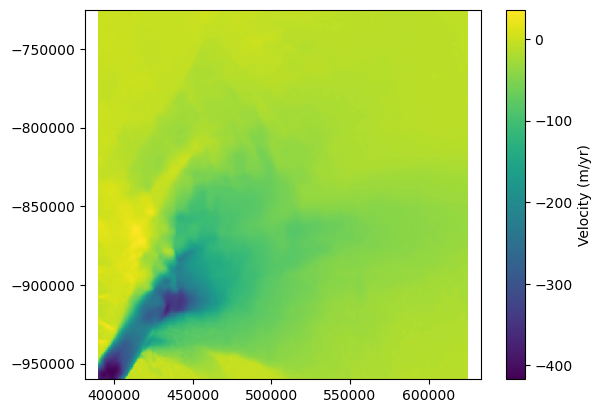

In [4]:
plt.pcolormesh(velocity_grid.x.values, velocity_grid.y.values, velocity_grid.VX.values, cmap = 'viridis')
plt.colorbar(label = 'Velocity (m/yr)')
plt.axis('equal')

(389825.0, 625175.0, -959975.0, -725075.0)

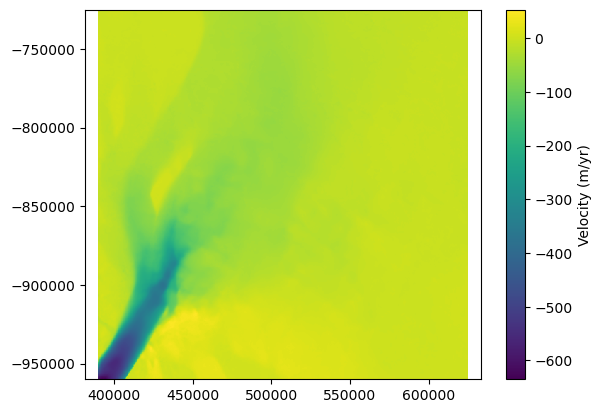

In [5]:
plt.pcolormesh(velocity_grid.x.values, velocity_grid.y.values, velocity_grid.VY.values, cmap = 'viridis')
plt.colorbar(label = 'Velocity (m/yr)')
plt.axis('equal')

In [6]:
print(f"Velocity extremes in Y directions:", velocity_grid.VY.max().item(), velocity_grid.VY.min().item())
print(f"Velocity extremes in X direction:", velocity_grid.VX.max().item(), velocity_grid.VX.min().item())

Velocity extremes in Y directions: 53.02280807495117 -635.0150756835938
Velocity extremes in X direction: 36.05989074707031 -417.02191162109375


## Get overview of ice thickness data

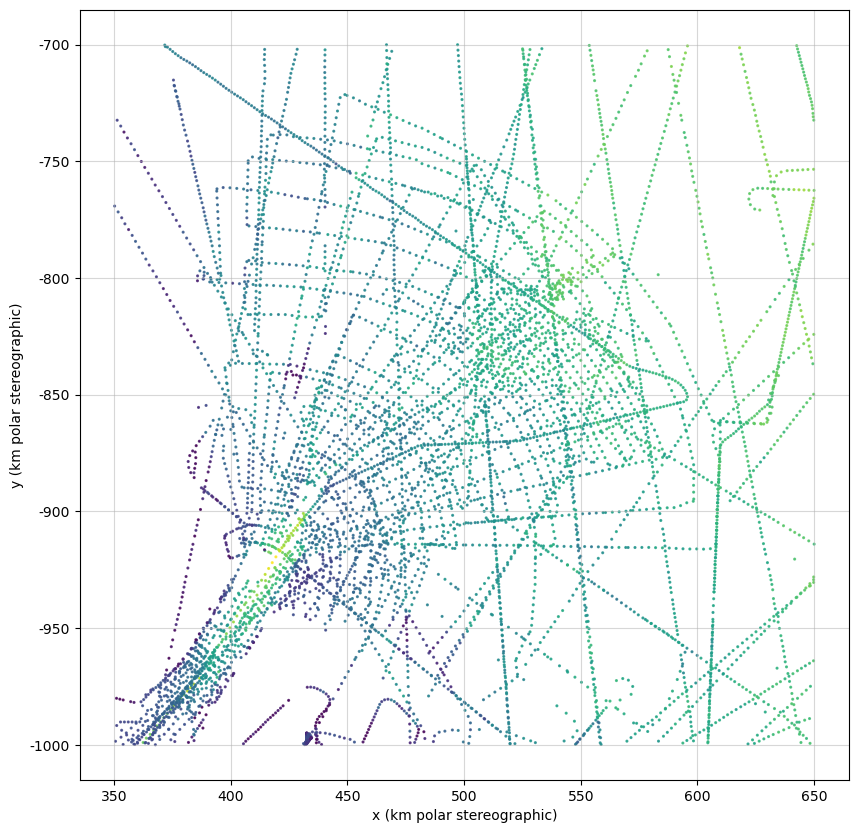

In [7]:
reduce_rate = 100
# sub-ample every 100th point to reduce the number of points for plotting
thickness_points_ss = thickness_points[::reduce_rate]

fig, ax = plt.subplots(figsize = (10, 10))
ax.scatter(thickness_points_ss['x'], thickness_points_ss['y'], c = thickness_points_ss['t'], s = 1.5, alpha = 0.8, cmap = 'viridis')

# Set both axes to use scientific notation with base 10^3
formatter = ticker.FuncFormatter(lambda x, pos: f'{x*1e-3:.0f}')
ax.xaxis.set_major_formatter(formatter)
ax.yaxis.set_major_formatter(formatter)

# Optional: label axes to clarify units
ax.set_xlabel("x (km polar stereographic)")
ax.set_ylabel("y (km polar stereographic)")

ax.set_aspect('equal')
ax.grid(True, alpha = 0.5)  # Show gridlines

## Visualise by survey

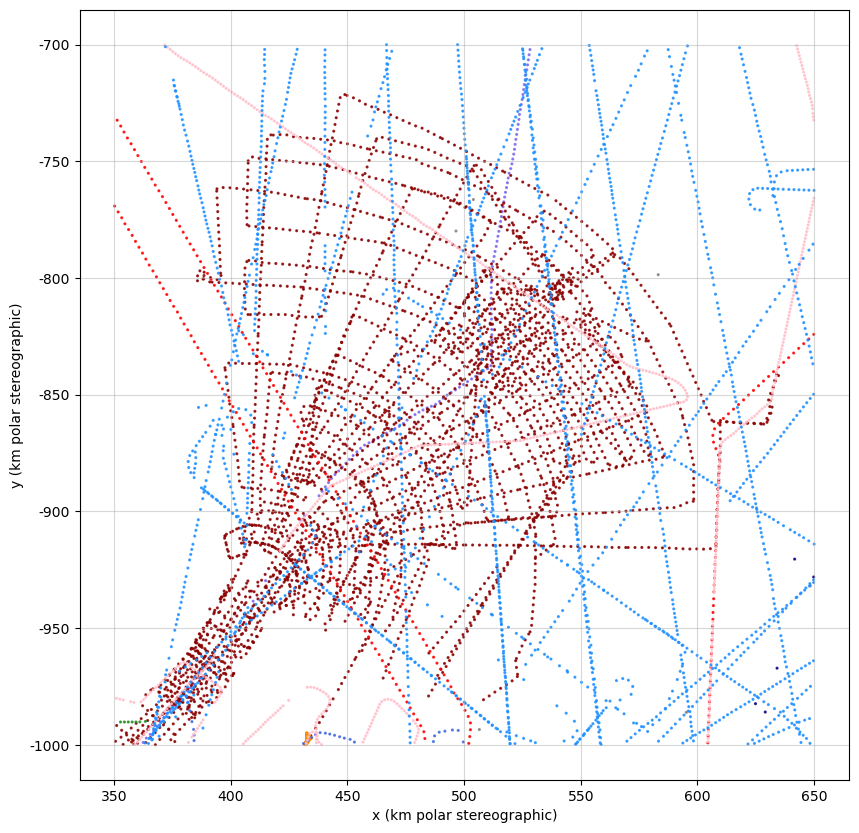

In [8]:
source_color_dict = {
    'BEDMAP1_1966-2000_AIR_BM1.csv': "gray",
    'NASA_2011_ICEBRIDGE_AIR_BM2.csv': "darkred",
    'NASA_2013_ICEBRIDGE_AIR_BM3.csv': "red",
    'NASA_2017_ICEBRIDGE_AIR_BM3.csv': "pink",
    'UTIG_1999_SOAR-LVS-WLK_AIR_BM2.csv': "navy",
    'UTIG_2004_AGASEA_AIR_BM2.csv': "mediumblue",
    'UTIG_2009_Darwin-Hatherton_AIR_BM3.csv': "royalblue",
    'UTIG_2010_ICECAP_AIR_BM3.csv': "dodgerblue",
    'BAS_2007_AGAP_AIR_BM2.csv': "mediumslateblue",
    'UCANTERBURY_2008_Darwin-Hatherton_GRN_BM2.csv': "darkorange",
    'LDEO_2015_ROSETTA_AIR_BM3.csv': "forestgreen"}

fig, ax = plt.subplots(figsize = (10, 10))
ax.scatter(
    thickness_points_ss['x'], 
    thickness_points_ss['y'],  
    s = 1.5, 
    alpha = 0.8, 
    color = thickness_points_ss['source'].map(source_color_dict))

# Set both axes to use scientific notation with base 10^3
formatter = ticker.FuncFormatter(lambda x, pos: f'{x*1e-3:.0f}')
ax.xaxis.set_major_formatter(formatter)
ax.yaxis.set_major_formatter(formatter)

# Optional: label axes to clarify units
ax.set_xlabel("x (km polar stereographic)")
ax.set_ylabel("y (km polar stereographic)")

ax.set_aspect('equal')
ax.grid(True, alpha = 0.5)  # Show gridlines

# Define regions for experiments

In [9]:
corners_regions = pd.DataFrame([
    # define full region again
    {"name": "RegionByrd", "x_min": 350 * 1000, "x_max": 650 * 1000, "y_min": -1000 * 1000, "y_max": -700 * 1000},
    # A - 25 x 25 km regions: quite zoomed in, similar to region C  
    # {"name": "RegionA", "x_min": 425 * 1000, "x_max": 450 * 1000, "y_min": -875 * 1000, "y_max": -850 * 1000},
    # B - linear flow, boring
    # {"name": "RegionB", "x_min": 450 * 1000, "x_max": 475 * 1000, "y_min": -875 * 1000, "y_max": -850 * 1000},
    # C - 25 x 25 km, fast flow
    {"name": "RegionC", "x_min": 420 * 1000, "x_max": 445 * 1000, "y_min": -905 * 1000, "y_max": -880 * 1000}, 
    # D - great for non-stationarity test
    {"name": "RegionD", "x_min": 410 * 1000, "x_max": 460 * 1000, "y_min": -850 * 1000, "y_max": -800 * 1000},
    # 70 x 70
    {"name": "RegionDlarger", "x_min": 395 * 1000, "x_max": 465 * 1000, "y_min": -870 * 1000, "y_max": -800 * 1000},#
    # E - 50 x 50 similar to C, too zoomed in
    # {"name": "RegionE", "x_min": 405 * 1000, "x_max": 430 * 1000, "y_min": -900 * 1000, "y_max": -875 * 1000},
    # F: a bit too small probably
    # {"name": "RegionF", "x_min": 400 * 1000, "x_max": 425 * 1000, "y_min": -890 * 1000, "y_max": -865 * 1000},
    {"name": "RegionFC", "x_min": 400 * 1000, "x_max": 450 * 1000, "y_min": -920 * 1000, "y_max": -870 * 1000},
    # G - Interesting 50 x 50 km region
    {"name": "RegionG", "x_min": 500 * 1000, "x_max": 550 * 1000, "y_min": -850 * 1000, "y_max": -800 * 1000},
    # H - Interesting 50 x 50 km region but not enough variance
    # {"name": "RegionH", "x_min": 450 * 1000, "x_max": 500 * 1000, "y_min": -950 * 1000, "y_max": -900 * 1000},
    # I: select strips
    {"name": "RegionI", "x_min": 400 * 1000, "x_max": 470 * 1000, "y_min": -800 * 1000, "y_max": -750 * 1000},
    {"name": "RegionJ", "x_min": 400 * 1000, "x_max": 450 * 1000, "y_min": -950 * 1000, "y_max": -900 * 1000},
])

In [10]:
corners_regions = pd.DataFrame([
    # define full region again
    {"name": "Region_Byrd", "x_min": 350 * 1000, "x_max": 650 * 1000, "y_min": -1000 * 1000, "y_max": -700 * 1000},
    # A - 
    {"name": "Region_upper_byrd", "x_min": 400 * 1000, "x_max": 470 * 1000, "y_min": -800 * 1000, "y_max": -730 * 1000},
    # B 
    {"name": "Region_mid_byrd", "x_min": 395 * 1000, "x_max": 465 * 1000, "y_min": -870 * 1000, "y_max": -800 * 1000},
    # C 
    {"name": "Region_lower_byrd", "x_min": 400 * 1000, "x_max": 450 * 1000, "y_min": -920 * 1000, "y_max": -870 * 1000}, 
])

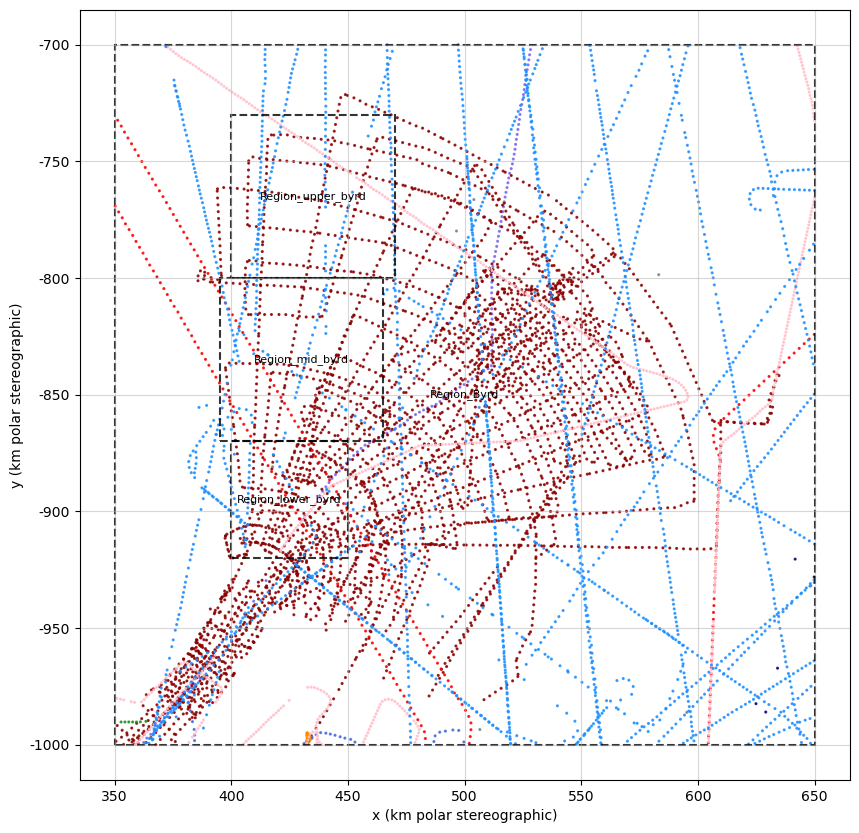

In [11]:
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from matplotlib import ticker

# Setup the figure
fig, ax = plt.subplots(figsize=(10, 10))

# Scatter plot
ax.scatter(
    thickness_points_ss['x'], 
    thickness_points_ss['y'],  
    s=1.5, 
    alpha=0.8, 
    color=thickness_points_ss['source'].map(source_color_dict)
)

# Set axes to scientific notation (in km)
formatter = ticker.FuncFormatter(lambda x, pos: f'{x*1e-3:.0f}')
ax.xaxis.set_major_formatter(formatter)
ax.yaxis.set_major_formatter(formatter)

# Labels
ax.set_xlabel("x (km polar stereographic)")
ax.set_ylabel("y (km polar stereographic)")

# Grid and aspect
ax.set_aspect('equal')
ax.grid(True, alpha=0.5)

# Define and add rectangles
for _, region in corners_regions.iterrows():
    width = region["x_max"] - region["x_min"]
    height = region["y_max"] - region["y_min"]
    rect = Rectangle(
        (region["x_min"], region["y_min"]),
        width,
        height,
        linewidth=1.5,
        edgecolor="black",
        facecolor="none",
        alpha=0.8,
        linestyle="--",
        label=region["name"]
    )
    ax.add_patch(rect)
    # Optionally label the region in the middle
    ax.text(
        region["x_min"] + width / 2,
        region["y_min"] + height / 2,
        region["name"],
        color="black",
        fontsize=8,
        ha="center",
        va="center"
    )

plt.show()

Subsampled data shape: (190, 17)


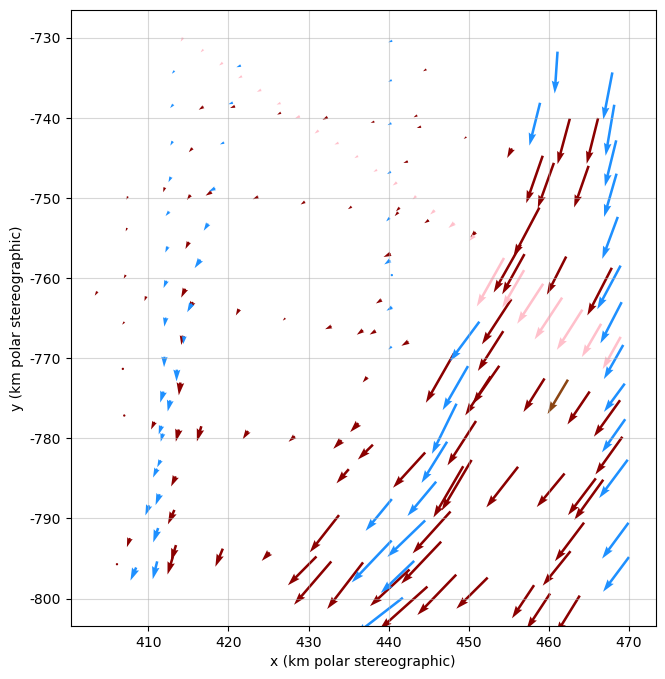

In [12]:
region_name = "Region_upper_byrd"

region_df = create_flux_df_for_region(
    region_name, thickness_points, velocity_grid, corners_regions, subsample_rate = 200)

# print(region_df.isna().sum())
region_df = region_df.dropna()

# Visualise with color corresponing to survey/source
visualise_flux(
    region_df, source_color = True)

Subsampled data shape: (273, 17)


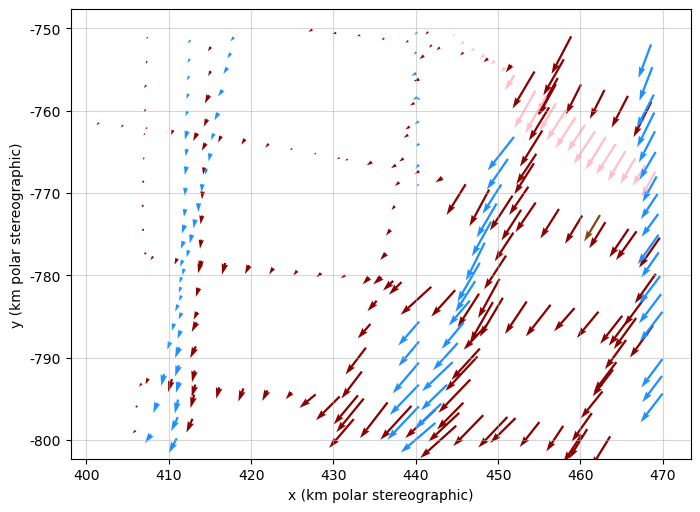

In [57]:
region_name = "RegionI"

region_df = create_flux_df_for_region(
    region_name, thickness_points, velocity_grid, corners_regions, subsample_rate = 100)

# print(region_df.isna().sum())
region_df = region_df.dropna()

# Visualise with color corresponing to survey/source
visualise_flux(
    region_df, source_color = True)

# FC

Subsampled data shape: (256, 17)


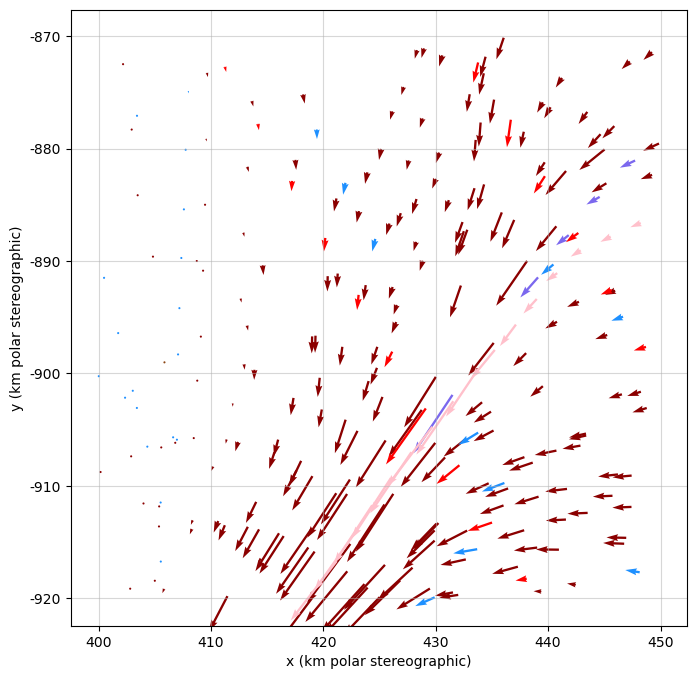

In [31]:
region_name = "RegionFC"

region_df = create_flux_df_for_region(
    region_name, thickness_points, velocity_grid, corners_regions, subsample_rate = 200)

# print(region_df.isna().sum())
region_df = region_df.dropna()

# Visualise with color corresponing to survey/source
visualise_flux(
    region_df, source_color = True)

In [22]:
def create_flux_df_for_region(region_name, thickness_points, velocity_grid, corners_regions, subsample_rate = 20):
    """
    Create a DataFrame containing ice thickness and corresponding ice velocity data for a specified region.
    
    Parameters:
    - region_name: Name of the region to process.
    - thickness_points: DataFrame containing ice thickness points.
    - velocity_grid: xarray DataArray containing ice velocity data.
    
    Returns:
    - thickness_velocity_df: DataFrame with combined ice thickness and velocity data for the specified region.
    """
    
    # Get the coordinates of the corners of the selected region

    x_min, x_max, y_min, y_max = corners_regions.loc[corners_regions.name == region_name, ["x_min", "x_max", "y_min", "y_max"]].values[0]

    # Step 1: Crop the region
    thickness_points_region = thickness_points[
        (thickness_points["x"] > x_min) & 
        (thickness_points["x"] < x_max) & 
        (thickness_points["y"] > y_min) & 
        (thickness_points["y"] < y_max)]

    # Step 2: Subsample the data
    thickness_points_region_df = thickness_points_region[::subsample_rate]

    # Step 3: Interpolate ice velocity data at thickness point locations
    # Subset columns of interest first to speed up interpolation operation
    velocity_grid_ss = velocity_grid[["VX", "VY", "ERRX", "ERRY"]]
    # Drop the coordinates we don't need for the interpolation
    velocity_grid_ss = velocity_grid_ss.reset_coords(drop = True)

    # Interpolate ice velocity variables (VX, VY, ERRX, ERRY) at all combinations of x and y points from the selected region
    velocity_grid_interpolated = velocity_grid_ss.interp(
        y = (thickness_points_region_df["y"]), 
        x = (thickness_points_region_df["x"]), 
        method = "cubic") # smooth interpolation

    # I. Extract the diagonal values from each DataArray
    VX_diag = np.diag(velocity_grid_interpolated.VX.values)
    VY_diag = np.diag(velocity_grid_interpolated.VY.values)
    ERRX_diag = np.diag(velocity_grid_interpolated.ERRX.values)
    ERRY_diag = np.diag(velocity_grid_interpolated.ERRY.values)

    # II. Get the corresponding x and y coordinates
    x_coords = velocity_grid_interpolated.x.values
    y_coords = velocity_grid_interpolated.y.values

    # III. Create a DataFrame for the velocity points
    velocity_points_region_df = pd.DataFrame({
        "x_velocity": x_coords, # NOTE: for merging we indicate that these are the x coordinates of the ice velocity data
        "y_velocity": y_coords,
        "VX": VX_diag,
        "VY": VY_diag,
        "ERRX": ERRX_diag,
        "ERRY": ERRY_diag
    })
    # print(velocity_points_region_df)

    # Step 4: Combine thickness points and corresponding velocity points into a unified DataFrame
    thickness_velocity_df = pd.concat([
        thickness_points_region_df.reset_index(drop = True),
        velocity_points_region_df.reset_index(drop = True)],
        axis = 1) # concat along the columns

    # Check if the x and y coordinates match, and delete redundant columns 
    if (thickness_velocity_df["x"] == thickness_velocity_df["x_velocity"]).all() & (thickness_velocity_df["y"] == thickness_velocity_df["y_velocity"]).all():
        thickness_velocity_df = thickness_velocity_df.drop(columns = ["x_velocity", "y_velocity"]) # inplace column drop

    # Step 5: Compute flux
    thickness_velocity_df["xflux"] = thickness_velocity_df["VX"] * thickness_velocity_df["t"]
    thickness_velocity_df["yflux"] = thickness_velocity_df["VY"] * thickness_velocity_df["t"]
    # NOTE: We define the error as the produce of the VX error and the thickness 
    thickness_velocity_df["xflux_err"] = thickness_velocity_df["ERRX"] * thickness_velocity_df["t"]
    # NOTE: # We define the error as the produce of the VY error and the thickness
    # NOTE: There are no errors published for Bedmap points unfortunately
    thickness_velocity_df["yflux_err"] = thickness_velocity_df["ERRY"] * thickness_velocity_df["t"]

    print(f"Subsampled data shape: {thickness_velocity_df.shape}")

    return thickness_velocity_df

        x_velocity     y_velocity          VX         VY      ERRX      ERRY
0    422576.051790 -811999.780264  -25.716065 -34.927572  0.407032  0.557083
1    464667.424902 -867631.253045 -114.398550 -78.156066  0.301076  0.389562
2    463777.359549 -868183.065381 -118.350549 -74.494331  0.310899  0.401851
3    462890.369877 -868742.013714 -122.073140 -71.477829  0.326220  0.420306
4    461972.700530 -869262.287847 -125.587299 -73.463019  0.334971  0.431595
..             ...            ...         ...        ...       ...       ...
946  463946.109875 -866799.676870 -113.628431 -81.476850  0.282583  0.362355
947  395997.466419 -864714.207705   12.862901 -15.581174  1.571280  1.740187
948  397300.591267 -864719.662160   10.922444 -15.422186  0.932239  1.042444
949  398830.529178 -864809.028753    8.985171 -18.074528  0.847962  0.959304
950  400996.178468 -864969.432557    9.718442 -20.144139  1.042204  1.174824

[951 rows x 6 columns]
Subsampled data shape: (951, 17)


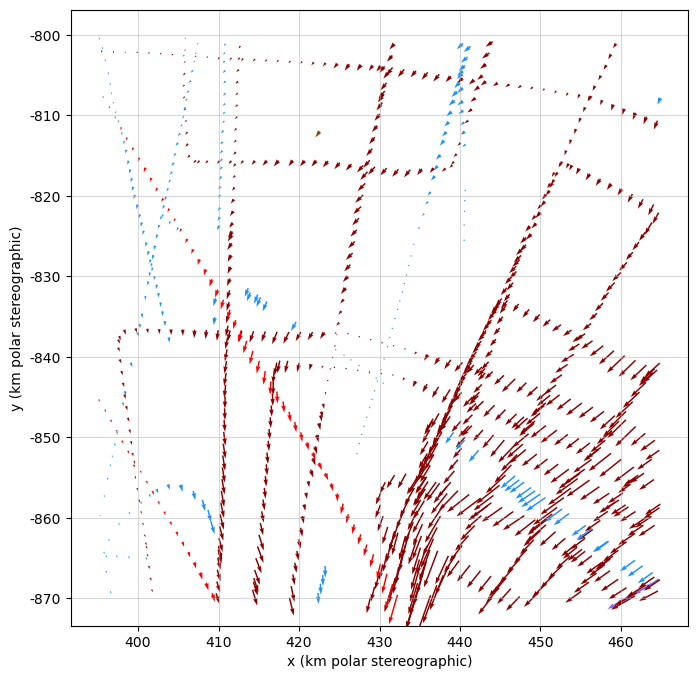

In [12]:
region_name = "RegionDlarger"

region_df = create_flux_df_for_region(
    region_name, thickness_points, velocity_grid, corners_regions, subsample_rate = 50)

# print(region_df.isna().sum())
region_df = region_df.dropna()

# Visualise with color corresponing to survey/source
visualise_flux(
    region_df, source_color = True)

Subsampled data shape: (726, 17)


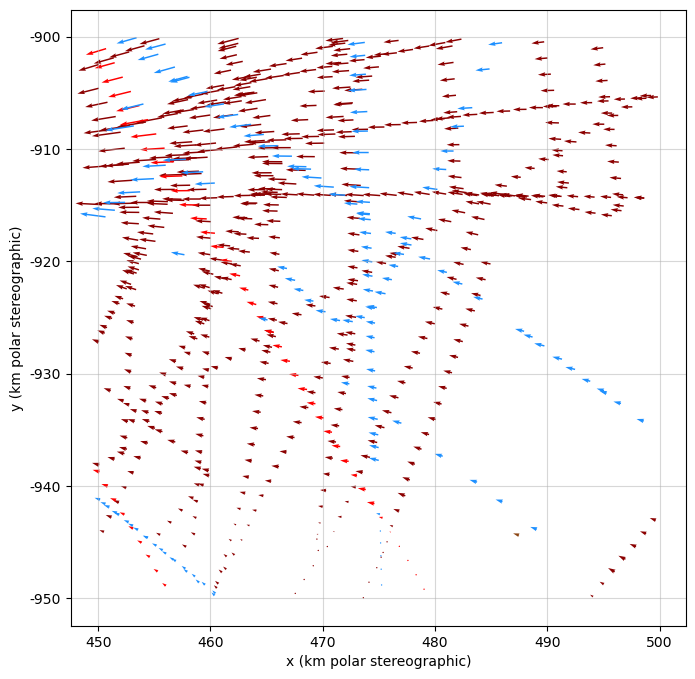

In [58]:
region_name = "RegionH"

region_df = create_flux_df_for_region(
    region_name, thickness_points, velocity_grid, corners_regions, subsample_rate = 50)

# print(region_df.isna().sum())
region_df = region_df.dropna()

# Visualise with color corresponing to survey/source
visualise_flux(
    region_df, source_color = True)

# Encode temporal mismatch and improvements in sensing technology

### NOTE: Noise additive or noise scaling year meter ice thickness? 

In [13]:
# define nominal year for surface velocity data, published 2017 (https://nsidc.org/sites/default/files/nsidc-0484-v002-userguide.pdf)
nominal_year = 2017

# add new column with the year of the survey
region_df["source_age"] = region_df["source"].str.extract(r"(\d{4})", expand = False).astype(int)
# use the mean for Bedmap1 temporal range (only this dataset combines all older surveys)
region_df.loc[region_df["source_age"] == 1966, "source_age"] = int(np.mean([1966, 2000])) # 1988
# calculate difference to nominal age
region_df["source_age"] = np.abs(region_df["source_age"] - nominal_year)

# NOTE: Noise additive or noise scaling year meter ice thickness? 

## Remove points that are clustered too close together

This will also help with singularity issues of GP matrices.

Minimum pairwise distance found among points in dataset (in m): 22.992
Number of rows to remove: 12
Rows to remove: {567, 776, 907, 336, 944, 626, 151, 889, 443, 699, 638, 639}


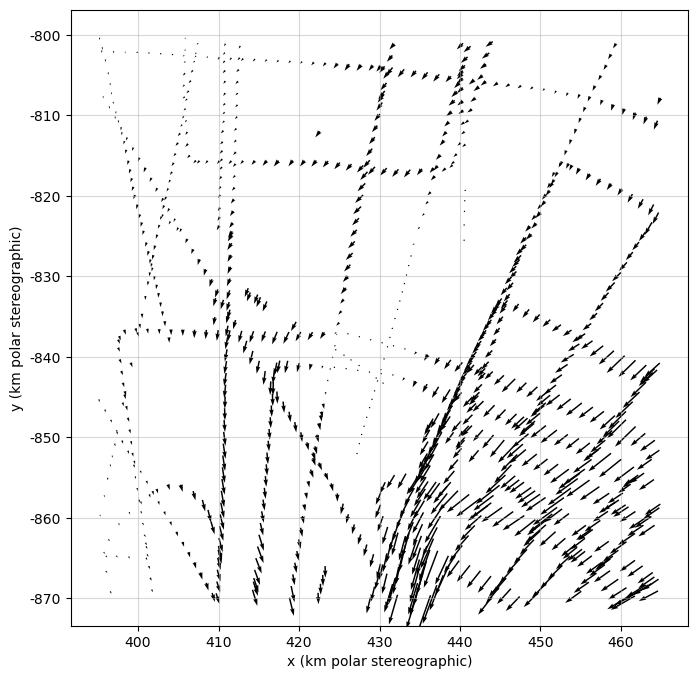

In [14]:
removal_indices = find_very_close_points(
    region_df, threshold = 200)

region_df_mindist = region_df.drop(removal_indices).reset_index(drop = True) # NOTE: reset indices is important

visualise_flux(region_df_mindist)

## Split data by cropping a big square out

The dataset contains 939 points.


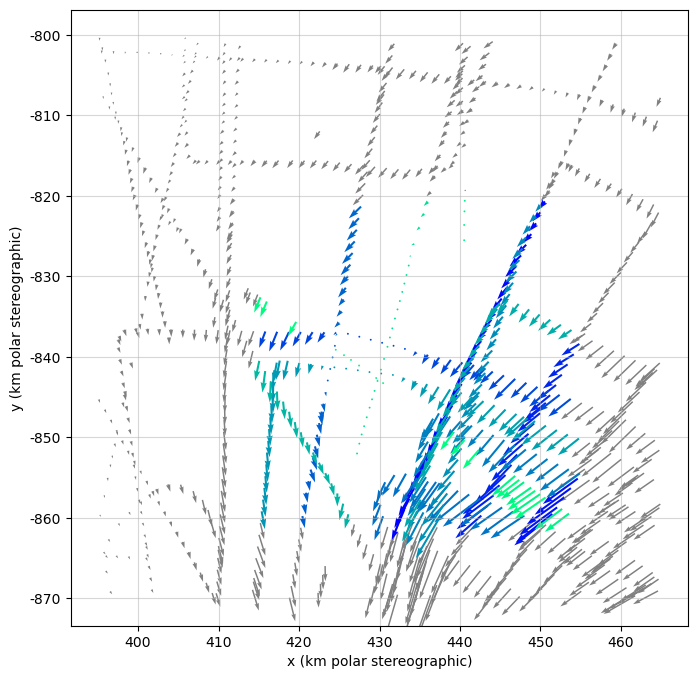

In [15]:
test_x_min = 415 * 1000
test_x_max = 455 * 1000
test_y_max = -820 * 1000
test_y_min = -860 * 1000
# 30 x 30 km gap - challenging for the model

test_indices = region_df_mindist[
        (region_df_mindist["x"] > test_x_min) & 
        (region_df_mindist["x"] < test_x_max) & 
        (region_df_mindist["y"] > test_y_min) & 
        (region_df_mindist["y"] < test_y_max)].index.tolist()

visualise_flux_train_test_split(region_df_mindist, test_indices, usecmap = "winter") # "turbo"

# Find flux_norm

 Aim at a mean of 1 or a std of 1

In [16]:
print(region_df_mindist["xflux"].mean())
print(region_df_mindist["yflux"].mean())

region_flux_scale = 60 * 1000

-55546.932738640855
-84630.33607320383


In [17]:
# Get remaining train indices
all_indices = list(range(region_df_mindist.shape[0]))
print(f"The dataset contains {len(all_indices)} points.")
train_indices = list(set(all_indices) - set(test_indices))

# extract boundries of the region
x_min, x_max, y_min, y_max = corners_regions[corners_regions["name"] == region_name].loc[:, ["x_min", "x_max", "y_min", "y_max"]].values[0].tolist()

region_train_tensor = df_to_tensor(
    region_df_mindist.iloc[train_indices], x_min, x_max, y_min, y_max, region_flux_scale)
region_test_tensor = df_to_tensor(
    region_df_mindist.iloc[test_indices], x_min, x_max, y_min, y_max, region_flux_scale)

print(f"Train tensor shape: {region_train_tensor.shape}")
print(f"Test tensor shape: {region_test_tensor.shape}")

The dataset contains 939 points.
Train tensor shape: torch.Size([8, 617])
Test tensor shape: torch.Size([8, 322])


In [18]:
region_train_tensor.mean(dim = 1), region_train_tensor.std(dim = 1)

(tensor([ 0.4519,  0.4909,  1.5480, -0.8094, -1.3617,  0.0164,  0.0207,  6.1540]),
 tensor([0.3288, 0.3392, 0.1829, 1.0123, 1.0955, 0.0082, 0.0100, 1.4041]))

Region D:  
region_flux_scale = 60 * 1000  
suface scale = 1000  
Size = 70 x 70 km (2 x Luxemburg)  

In [19]:
torch.save(region_train_tensor, "data/real_data/regiond_train_tensor.pt")
torch.save(region_test_tensor, "data/real_data/regiond_test_tensor.pt")

# Next

In [ ]:
region_name = "RegionC"
regionC_df = create_flux_df_for_region(region_name, thickness_points, velocity_grid, corners_regions, subsample_rate = 25)
# NOTE: remove maybe
# remove single point from bedmap
# regionC_df["source"].value_counts()
regionC_df = regionC_df[regionC_df.source != 'BEDMAP1_1966-2000_AIR_BM1.csv']

removal_indices = find_very_close_points(regionC_df, threshold = 10)

test_indices = list(list(range(107, 146)) # horizontal line
                    + list(range(356, 399)) # vertical line left
                    + list(range(509, 542)) # left corner
                    )
        
visualise_flux_train_test_split(regionC_df, test_indices, usecmap = "winter") # "turbo"

# Convert to tensor


In [ ]:
regionc_flux_scale = 200 * 1000

regionc_train_tensor = df_to_tensor(combined_df.iloc[train_indices], x_min, x_max, y_min, y_max, regionc_flux_scale)
regionc_test_tensor = df_to_tensor(combined_df.iloc[test_indices], x_min, x_max, y_min, y_max, regionc_flux_scale)

In [ ]:
print("Train maximum fluxes:")
print(regionc_train_tensor.T[:, 3].abs().max(), regionc_train_tensor.T[:, 4].abs().max())
print("Test maximum fluxes:")
print(regionc_test_tensor.T[:, 3].abs().max(), regionc_test_tensor.T[:, 4].abs().max())

## Export tensors

In [ ]:
torch.save(regionc_train_tensor, "data/real_data/regionc_train_tensor.pt")
torch.save(regionc_test_tensor, "data/real_data/regionc_test_tensor.pt")

# To Do

- write pipeline that gets us to byrd_bedmap_clean
- once we are happy with our regions we can save names with region_name and define the test indices, flux_scale and so in some dictionary to just run this script to generate all training and testing data. 

## Take cleaned data set

- Withhold some lines
- Distretise to grid to reduce num of data

In [ ]:
# byrd_bedmap_points = pd.read_csv('/home/kim/ice_thickness/data/byrd_200km.csv')
# clean has 457,451 rows, raw has 465,760 rows
byrd_bedmap_points_clean = pd.read_csv('/home/kim/ice_thickness/data/byrd_bedmap_points_clean.csv')

In [ ]:
byrd_bedmap_points_clean.value_counts("source")

In [ ]:
byrd_bedmap_points_clean[byrd_bedmap_points_clean.source == "BEDMAP1_1966-2000_AIR_BM1.csv"]

In [ ]:
cvals  = [0, # colors so that first value is green (if below 1 m ice thickness)
          1, 250, 500, 750, 1000]

colors = ["#7eb3a1",
          "#bee6fa", "#47bdfc", "#006cef", "#0023c1", "#001079"]

# Create a colormap object
norm = plt.Normalize(np.min(cvals), np.max(cvals))
tuples = list(zip(map(norm, cvals), colors))

icethickness_cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", tuples)

# Plot with 500k points

In [ ]:
fig, ax = plt.subplots(figsize = (10, 10))

# Plot data points
ax.scatter(byrd_bedmap_points_clean["x"], byrd_bedmap_points_clean["y"], 
           c = byrd_bedmap_points_clean["t"], 
           s = 2,
           cmap = icethickness_cmap, vmin = 0, vmax = 3500)

fig.colorbar(mappable = ax.collections[0], ax = ax)
ax.set_aspect('equal')

In [ ]:
color_dict = {'NASA_2011_ICEBRIDGE_AIR_BM2.csv': 'red', 
              'UTIG_2010_ICECAP_AIR_BM3.csv': 'green', 
              'NASA_2017_ICEBRIDGE_AIR_BM3.csv': 'pink',
              'NASA_2013_ICEBRIDGE_AIR_BM3.csv': 'purple',
              'LDEO_2015_ROSETTA_AIR_BM3.csv': 'blue',
              'BEDMAP1_1966-2000_AIR_BM1.csv': 'orange', # sparse points
              'UTIG_2004_AGASEA_AIR_BM2.csv': 'brown'}

fig, ax = plt.subplots(figsize = (10, 10))

# Plot data points
ax.scatter(byrd_bedmap_points_clean["x"], byrd_bedmap_points_clean["y"], 
           c = [color_dict[category] for category in byrd_bedmap_points_clean["source"]], 
           s = 2)

ax.set_aspect('equal')

# We define the coordinates of our experimental regions

- We write out the polar stereographic coordinates (EPSG:3031) for every square.
- We write the coordinates in kilometer units (* 1000) for easier readability.
- Currently out regions are 25 * 25 km

- subsampling will still keep it irregulaly spaced. Off-grid

In [ ]:
def load_and_preprocess_ice_velocity_data(file_path):
    """
    Load and preprocess ice velocity data from a NetCDF file.
    
    Inputs:
        file_path (str): Path to the NetCDF file.
        
    Returns:
        xarray.DataArray: Preprocessed ice velocity data.
    """
    # Load the NetCDF file
    # loading works with base(Python 3.8.12)
    ice_vel_all_of_antarctica = xr.open_dataset(file_path)

    # Data file is large so crop to the "broader Byrd region" to reduce memory usage
    corners_byrd_regions = pd.read_csv("data/real_data/corners_broader_byrd_region.csv")

    x_min, x_max, y_min, y_max = corners_byrd_regions.loc[corners_byrd_regions.name == "Byrd", ["x_min", "x_max", "y_min", "y_max"]].values[0]

    ice_vel_byrd = ice_vel_all_of_antarctica.sel(x = slice(x_min, x_max), y = slice(y_max, y_min)) # reverse order
    
    return ice_vel_byrd

file_path = '/home/kim/data/nsidc/antarctica_ice_velocity_450m_v2.nc'
ice_vel_xr = load_and_preprocess_ice_velocity_data(file_path)

# Interpolate ice vel in xarray

In [ ]:
bedmap_points_region["y"]

In [ ]:
ice_vel_xr_interpolated = ice_vel_xr.interp(y = (bedmap_points_region["y"]), x = (bedmap_points_region["x"]), method = "nearest")

In [ ]:
# interpolate ice_vel [VX, VY, ERRX, ERRY] to 1 km grid
ice_vel_xr

In [ ]:
bedmap_points_region

In [ ]:
# 25 km / 500 m grid: 50 x 50 grid cells
x_min = 425 * 1000
x_max = 450 * 1000
y_max = -850 * 1000
y_min = -875 * 1000

byrd_bedmap_points_zoom = byrd_bedmap_points_clean[
    (byrd_bedmap_points_clean["x"] > x_min) & 
    (byrd_bedmap_points_clean["x"] < x_max) & 
    (byrd_bedmap_points_clean["y"] > y_min) & 
    (byrd_bedmap_points_clean["y"] < y_max)]

byrd_bedmap_points_zoom

In [ ]:
byrd_bedmap_points_zoom_subsample = byrd_bedmap_points_zoom[::10]

In [ ]:
fig, ax = plt.subplots(figsize = (10, 10))


# Plot data points
ax.scatter(byrd_bedmap_points_zoom_subsample["x"], byrd_bedmap_points_zoom_subsample["y"], 
           c = [color_dict[category] for category in byrd_bedmap_points_zoom_subsample["source"]], 
           s = 2)
byrd_bedmap_points_zoom_subset = byrd_bedmap_points_zoom[0:1000]
ax.scatter(byrd_bedmap_points_zoom_subset["x"], byrd_bedmap_points_zoom_subset["y"], color = "black",
           s = 2)

ax.set_aspect('equal')

In [ ]:
fig, ax = plt.subplots(figsize = (10, 10))


# Plot data points
ax.scatter(byrd_bedmap_points_zoom["x"], byrd_bedmap_points_zoom["y"], 
           c = [color_dict[category] for category in byrd_bedmap_points_zoom["source"]], 
           s = 2)
byrd_bedmap_points_zoom_subset = byrd_bedmap_points_zoom[0:1000]
ax.scatter(byrd_bedmap_points_zoom_subset["x"], byrd_bedmap_points_zoom_subset["y"], color = "black",
           s = 2)

ax.set_aspect('equal')

# Use natural ordering to subsample the frequency & to seperate train and test.
We can use a larger area but more subsampling! Still no gridding needed... 
Try model with x, y, s input too!